In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# code adapted from ChatGPT

# Define the neural network model
class Q_learning_NN(nn.Module):
    def __init__(self):
        super(Q_learning_NN, self).__init__()

        self.step1 = nn.Linear(3, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 1, bias=True)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = Q_learning_NN()
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.float()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.float()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        scheduler.step()
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [49]:
df = pd.read_csv("../Data_Generation/Data_files/Q_moves_scores.csv")
df = df.drop('num_moves_Q_learning_needs', axis=1)

In [50]:
just_input = df.drop('last_matrix', axis=1)
just_input = just_input.drop('first_move_by_Q_learning', axis=1)
just_input = just_input.drop('Q_table_val', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())

In [51]:
desired_output = torch.tensor(df['Q_table_val'].tolist(), dtype=torch.float32).float()

C:\Users\16089\AppData\Local\Temp\ipykernel_20048\849708374.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
C:\Users\16089\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\16089\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([961

total loss: 502263848.0
Epoch [1/500], Loss: 83710641.3333
total loss: 501800312.0
Epoch [2/500], Loss: 83633385.3333
total loss: 500731752.0
Epoch [3/500], Loss: 83455292.0000
total loss: 498435384.0
Epoch [4/500], Loss: 83072564.0000
total loss: 494526280.0
Epoch [5/500], Loss: 82421046.6667
total loss: 488136416.0
Epoch [6/500], Loss: 81356069.3333
total loss: 478232976.0
Epoch [7/500], Loss: 79705496.0000
total loss: 463356376.0
Epoch [8/500], Loss: 77226062.6667
total loss: 442793912.0
Epoch [9/500], Loss: 73798985.3333
total loss: 415516496.0
Epoch [10/500], Loss: 69252749.3333
total loss: 381624680.0
Epoch [11/500], Loss: 63604113.3333
total loss: 342498268.0
Epoch [12/500], Loss: 57083044.6667
total loss: 301356116.0
Epoch [13/500], Loss: 50226019.3333
total loss: 264018456.0
Epoch [14/500], Loss: 44003076.0000
total loss: 236923584.0
Epoch [15/500], Loss: 39487264.0000
total loss: 224771056.0
Epoch [16/500], Loss: 37461842.6667
total loss: 220520644.0
Epoch [17/500], Loss: 367

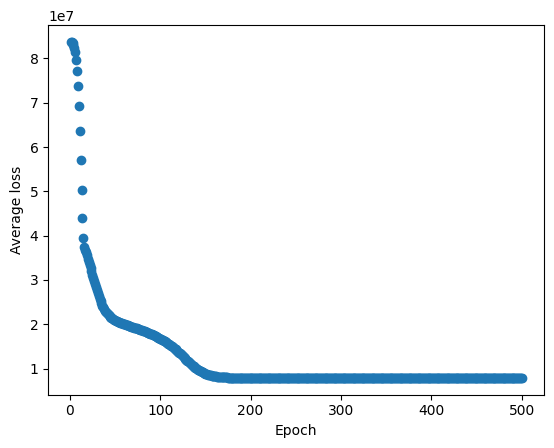

In [52]:
# Train the model
trained_model = train_model(input_data, desired_output, 500, learning_rate=0.002, viz_accuracy=True)

In [53]:
def matrix_to_list(matrix):
    return [matrix[0][1], matrix[0][2], matrix[1][2]]
def list_to_matrix(tuple):
    return np.array([[1, tuple[0], tuple[1]], [0, 1, tuple[2]], [0, 0, 1]])

In [54]:
A = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]])
C = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = np.array([[1, 0, 0], [0, 1, -1], [0, 0, 1]])

In [55]:
def test_a_point(myList):
    mat = list_to_matrix(myList)
    first = float(trained_model(torch.tensor(matrix_to_list(mat @ A)).float()))
    second = float(trained_model(torch.tensor(matrix_to_list(mat @ B)).float()))
    third = float(trained_model(torch.tensor(matrix_to_list(mat @ C)).float()))
    fourth = float(trained_model(torch.tensor(matrix_to_list(mat @ D)).float()))
    return np.argmax([first, second, third, fourth])


In [56]:
test_df = pd.read_csv("../Data_Generation/Data_files/Q_moves_scores_test.csv")
test_df = test_df.drop('num_moves_Q_learning_needs', axis=1)
just_input_test = test_df.drop('first_move_by_Q_learning', axis=1)
just_input_test = just_input_test.drop('Q_table_val', axis=1)
just_input_test = just_input_test.drop('last_matrix', axis=1)

input_data_test = np.array(just_input_test.values.tolist())
desired_output = test_df['first_move_by_Q_learning'].tolist()

In [57]:
test_df['first_move_by_Q_learning']

0       2
1       1
2       1
3       1
4       2
       ..
3969    3
3970    1
3971    0
3972    2
3973    3
Name: first_move_by_Q_learning, Length: 3974, dtype: int64

In [58]:
test_a_point(input_data_test[4])

0

In [59]:
outputs = []
for i in range(len(input_data_test)):
    outputs.append(test_a_point(input_data_test[i]))

In [60]:
float(sum(torch.tensor(desired_output) == torch.tensor(outputs)) / len(outputs))

0.225213885307312

In [81]:
demo_test_type = torch.tensor([0, 1, 1], dtype=torch.float32)

def nn_prediction(point):
    options = []
    options.append(float(trained_model(torch.tensor([matrix_to_list(list_to_matrix(point) @ A)], dtype=torch.float32))))
    options.append(float(trained_model(torch.tensor([matrix_to_list(list_to_matrix(point) @ B)], dtype=torch.float32))))
    options.append(float(trained_model(torch.tensor([matrix_to_list(list_to_matrix(point) @ C)], dtype=torch.float32))))
    options.append(float(trained_model(torch.tensor([matrix_to_list(list_to_matrix(point) @ D)], dtype=torch.float32))))
    return np.argmax(options)

In [75]:
C @ D

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

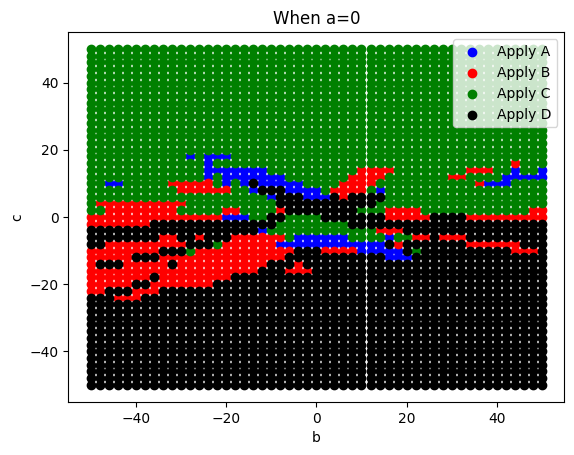

In [82]:
# plot a vizualization of what we would predict for a bunch of ordered pairs

confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([0, i, j], dtype=torch.float32)
        confidence = nn_prediction(demo_test_type)
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("b")
plt.ylabel("c")
plt.title("When a=0")
plt.legend()
plt.show()

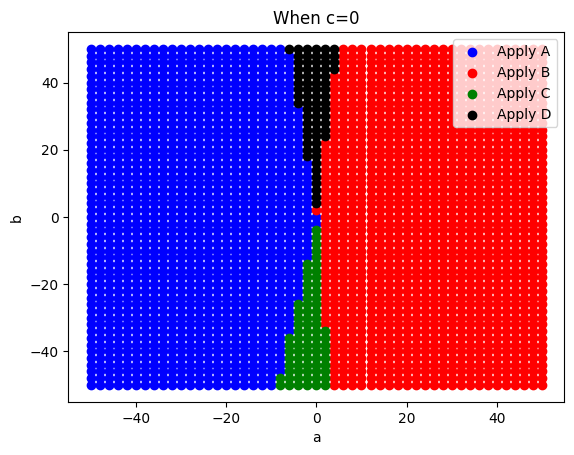

In [ ]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([0, i, j], dtype=torch.float32)
        confidence = nn_prediction(demo_test_type)
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("b")
plt.title("When c=0")
plt.legend()
plt.show()

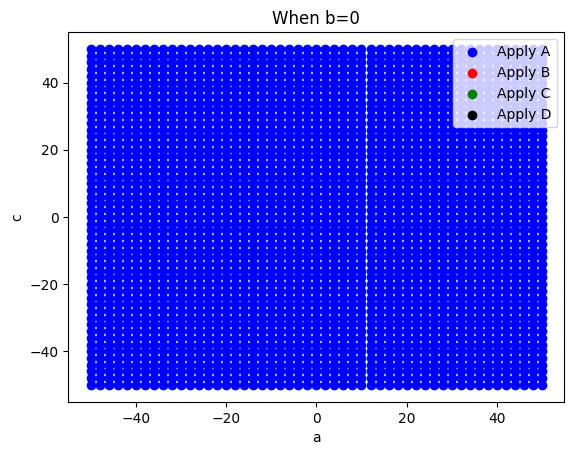

In [ ]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([0, i, j], dtype=torch.float32)
        confidence = nn_prediction(demo_test_type)
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("c")
plt.title("When b=0")
plt.legend()
plt.show()

In [3]:
# B is the inverse of A
A = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]])

# C is the inverse of D
C = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = np.array([[1, 0, 0], [0, 1, -1], [0, 0, 1]])

identity = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [5]:
A@A@D

array([[ 1,  2, -2],
       [ 0,  1, -1],
       [ 0,  0,  1]])

: 

In [86]:
# how long does it take us to get back to the origin? 
def matrix_to_tuple(matrix):
    return (matrix[0][1], matrix[0][2], matrix[1][2])

def num_steps_to_origin_w_nn(mat):
    for i in range(100):

        if (mat==identity).all():
            return i
        
        demo_test_type = torch.tensor(matrix_to_list(mat), dtype=torch.float32)
        action = nn_prediction(demo_test_type)        

        if action==0:
            mat = mat @ A
        elif action==1:
            mat = mat @ B
        elif action==2:
            mat = mat @ C
        else:
            mat = mat @ D

    return 1000

In [87]:
test_mat = np.array([[1, 1, 1], [0, 1, 1], [0, 0, 1]])
num_steps_to_origin_w_nn(test_mat)

[[1 1 1]
 [0 1 1]
 [0 0 1]]
1
[[1 0 1]
 [0 1 1]
 [0 0 1]]
3
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 [ 0  1 -1]
 [ 0  0  1]]
2
[[1 0 1]
 [0 1 0]
 [0 0 1]]
3
[[ 1  0  1]
 

1000

In [88]:
demo_test_type = torch.tensor([[1, 0, 0]], dtype=torch.float32)
confidence = int(torch.argmax(trained_model(demo_test_type)))
trained_model(demo_test_type)

tensor([[9243.6367]], grad_fn=<AddmmBackward0>)

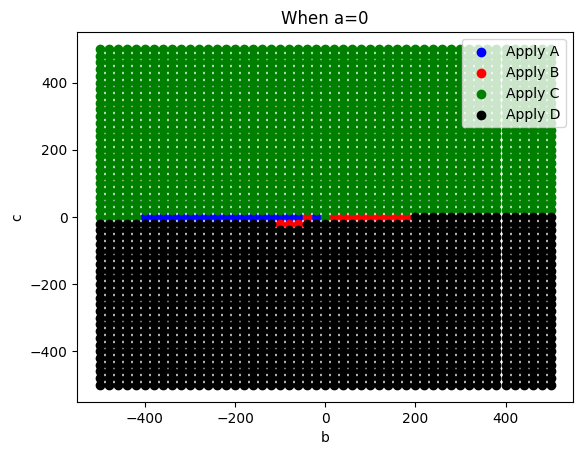

In [90]:
# plot a vizualization of what we would predict for a bunch of ordered pairs

confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-500, 501, 20):
    for j in range(-500, 501, 20):
        demo_test_type = torch.tensor([0, i, j], dtype=torch.float32)
        confidence = nn_prediction(demo_test_type)
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("b")
plt.ylabel("c")
plt.title("When a=0")
plt.legend()
plt.show()

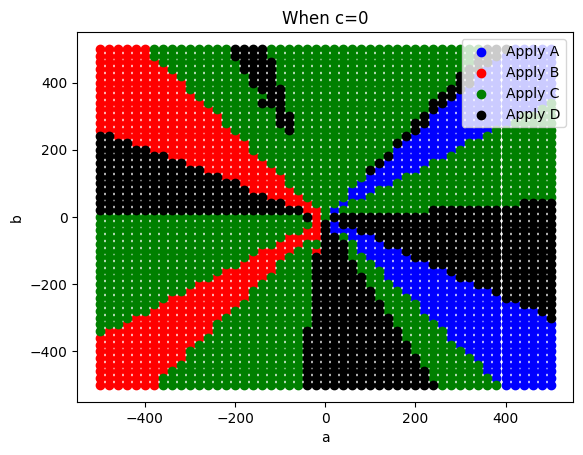

In [93]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-500, 501, 20):
    for j in range(-500, 501, 20):
        demo_test_type = torch.tensor([i, 0, j], dtype=torch.float32)
        confidence = nn_prediction(demo_test_type)
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("b")
plt.title("When c=0")
plt.legend()
plt.show()

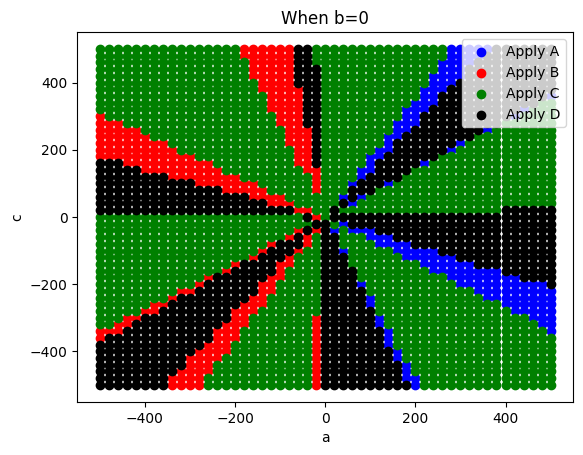

In [94]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-500, 501, 20):
    for j in range(-500, 501, 20):
        demo_test_type = torch.tensor([i, j, j], dtype=torch.float32)
        confidence = nn_prediction(demo_test_type)
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("c")
plt.title("When b=0")
plt.legend()
plt.show()